*Connect the dataset*

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
import cv2
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
import pandas as pd
from skimage.transform import resize
from tqdm import tqdm
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import shutil
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, ZeroPadding2D,Convolution2D
from keras.layers import Flatten
from keras.layers import Dense
import tensorflow as tf
from keras.optimizers import RMSprop, SGD, Adam
from keras.layers import Dropout,Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Flatten, Dense, Dropout

In [86]:
training_folder = "/content/drive/MyDrive/computing project/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
training_mask_folder = "/content/drive/My Drive/computing project/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth"
test_folder = "/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data"
training_folder_resize="/content/drive/MyDrive/computing project/training_folder_resize"
training_mask_folder_resize="/content/drive/MyDrive/computing project/training_mask_folder_resize"
test_folder_resize="/content/drive/MyDrive/computing project/test_folder_resize"
test_mask_folder="/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part1_GroundTruth"
test_mask_folder_resize="/content/drive/MyDrive/computing project/test_folder_mask_resize"
training_Otsu_images="/content/drive/MyDrive/computing project/Trainig_otsu"
training_Otsu_images_resize="/content/drive/MyDrive/computing project/train_otsu-resize"
test_Otsu_images="/content/drive/MyDrive/computing project/test_Otsu_images"
test_Otsu_images_resize="/content/drive/MyDrive/computing project/test_otsu-resize"
Train_labl="/content/drive/MyDrive/computing project/ISIC-2017_Training_GroundTruth.csv"
test_lable="/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_GroundTruth.csv"
test_dir='/content/drive/MyDrive/computing project/ISIC_2017_TEST_Dir/'
train_dir='/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir/'

get the IDs for the images

In [ ]:
#training images and masks ids
train_im=  pd.read_csv("/content/drive/MyDrive/computing project/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv")
train_ids=train_im['image_id']
Train_mask_ids= train_im['image_id']+'_segmentation'
#testing image and mask ids
test_im= pd.read_csv("/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_GroundTruth.csv")
test_ids=test_im['image_id']
test_mask_ids= test_im['image_id']+'_segmentation'

Creat a segmentation using Otsu

In [ ]:
def OTSU_segmentation(Path,image,imagetype):
  im = cv2.imread(Path+'/'+image+'.'+imagetype,cv2.IMREAD_GRAYSCALE)
  
  img = cv2.GaussianBlur(im,(5,5),0)
  ret,thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  thresh1=convertToBinary(ret,thresh)
  return thresh1
def convertToBinary(t, img):  
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i, j] >= t):
                img[i, j] = 0
            else:
                img[i, j] = 255
    return img


In [ ]:
def segment_images(path,ids,saving_path):
 for id in tqdm(ids):
   im=OTSU_segmentation(path,id,"jpg")
   cv2.imwrite(saving_path+'/'+id+'.png',im)
 print('done!')
 return

In [ ]:
print("segment training folder with otsu")
sys.stdout.flush() 
segment_images(training_folder,train_ids,training_Otsu_images)

segment training folder with otsu
done!


In [ ]:
print('segment testing folder with otsu')
sys.stdout.flush()
segment_images(test_folder,test_ids,test_Otsu_images)

segment testing folder with otsu
done!


In [87]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
batch_size = 16


Resizing th image into (128, 128)

In [ ]:
def resize_images(path,ids,saving_path,image_type):
 sys.stdout.flush()
 for id in tqdm(ids) :
   img = imread(path + '/' + id + '.'+image_type)
   if img.shape[0]>128 and img.shape[1]>128:
      img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      cv2.imwrite(saving_path+'/'+id+'.'+image_type,img)
  
 print('done!')
 return

In [ ]:
print('resizing the test otsu mask')
sys.stdout.flush()
resize_images(training_Otsu_images,train_ids,training_Otsu_images_resize,'png')

resizing the test otsu mask


100%|██████████| 2000/2000 [40:15<00:00,  1.21s/it]

done!


In [ ]:
print('resizing the test otsu mask')
sys.stdout.flush()
resize_images(test_Otsu_images,test_ids,test_Otsu_images_resize,'png')

resizing the test otsu mask


100%|██████████| 600/600 [35:35<00:00,  3.56s/it]

done!


In [ ]:
print('resizing the test mask')
sys.stdout.flush()
resize_images(test_mask_folder,test_mask_ids,test_mask_folder_resize,'png')

resizing the test mask


100%|██████████| 600/600 [38:01<00:00,  3.80s/it]

done!


# Binary classification

Creat a new column called class




In [ ]:
df = pd.read_csv("/content/drive/MyDrive/computing project/ISIC-2017_Training_Part3_GroundTruth.csv")
conditions = [
    (df['melanoma'] ==1),
    (df['melanoma'] ==0) 
            ]
values = [0,1]
df['class'] = np.select(conditions, values)
df.to_csv("/content/drive/MyDrive/computing project/ISIC-2017_Training_GroundTruth.csv")
print('NEW CSV FILE HAS BEEN ADDED')

NEW CSV FILE HAS BEEN ADDED


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_Part3_GroundTruth.csv")
conditions = [
    (df['melanoma'] ==1),
    (df['melanoma'] ==0) ,
          ]
values = [0,1]
df['class'] = np.select(conditions, values)
df.to_csv("/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_GroundTruth.csv")
print('NEW CSV FILE HAS BEEN ADDED')

NEW CSV FILE HAS BEEN ADDED


In [ ]:
def get_lable(csv_path,IDs):
 labels = pd.read_csv(csv_path)
 Y = []
 N=IDs
 for i in range(len(N)):
  if N[i]== labels['image_id'][i]:
     Y= Y + [int(labels['class'][i])]
 return Y
   

In [ ]:
Class_name=['melanom','other']

Creat a directory

In [ ]:
def creat_Dir_train(csv):
  df = pd.read_csv(csv)
  sys.stdout.flush()
  for i in tqdm(range(len(df))):
    image_id= df['image_id'][i]
    clas = df['class'][i]
    if clas == 0 : 
      original = training_folder_resize+'/'+image_id+'.jpg'
      target = '/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir/0/'+image_id+'.jpg'
      shutil.copyfile(original, target)
    
    elif clas == 1 : 
      original = training_folder_resize+'/'+image_id+'.jpg'
      target = '/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir/1/'+image_id+'.jpg'
      shutil.copyfile(original, target)
     




In [ ]:
creat_Dir_train('/content/drive/MyDrive/computing project/ISIC-2017_Training_GroundTruth.csv')

100%|██████████| 2000/2000 [00:22<00:00, 88.30it/s]


In [ ]:
def creat_Dir_test(csv):
  df = pd.read_csv(csv)
  sys.stdout.flush()
  for i in tqdm(range(len(df))):
    image_id= df['image_id'][i]
    clas = df['class'][i]
    if clas == 0 : 
      original = test_folder_resize+'/'+image_id+'.jpg'
      target = '/content/drive/MyDrive/computing project/ISIC_2017_TEST_Dir/0/'+image_id+'.jpg'
      shutil.copyfile(original, target)
    
    elif clas == 1 : 
      original = test_folder_resize+'/'+image_id+'.jpg'
      target = '/content/drive/MyDrive/computing project/ISIC_2017_TEST_Dir/1/'+image_id+'.jpg'
      shutil.copyfile(original, target)
      '''
    elif clas == 2 :
      original = test_folder_resize+'/'+image_id+'.jpg'
      target = '/content/drive/MyDrive/computing project/ISIC_2017_TEST_Dir/2/'+image_id+'.jpg'
      shutil.copyfile(original, target)
      '''

In [ ]:
creat_Dir_test('/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_GroundTruth.csv')

100%|██████████| 600/600 [00:07<00:00, 85.14it/s]


loading the data set

In [ ]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='int',
    class_names=["0","1"], color_mode='rgb', batch_size=batch_size, image_size=(IMG_HEIGHT,
    IMG_WIDTH), shuffle=True, seed=300, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)


Found 2000 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, labels='inferred', label_mode='int',
    class_names=["0","1"], color_mode='rgb', batch_size=batch_size, image_size=(IMG_HEIGHT,
    IMG_WIDTH), shuffle=True, seed=300, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)



Found 600 files belonging to 2 classes.


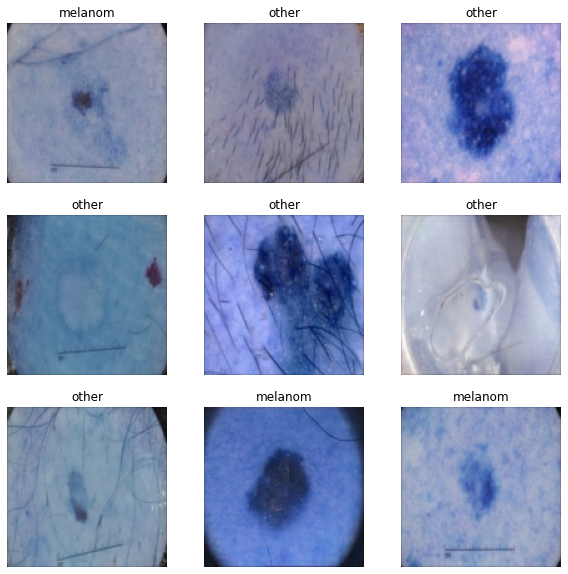

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(Class_name[labels[i]])
    plt.axis("off")


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(16, 128, 128, 3)
(16,)


In [88]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


normalaization 

In [89]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.019607844 1.0


Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


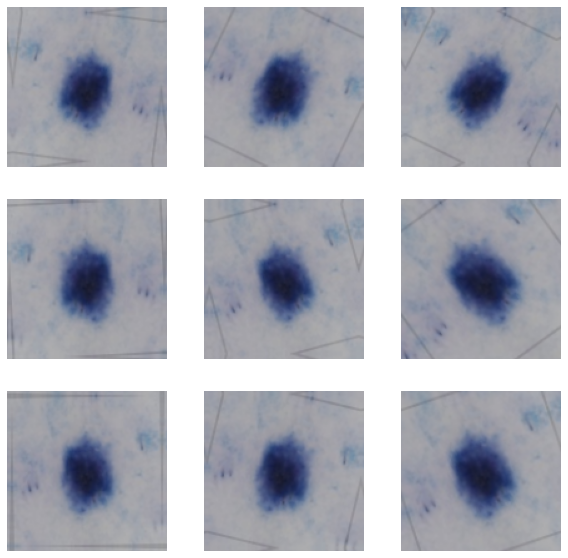

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Creat the model

In [ ]:
model = Sequential()
data_augmentation,
# First CONV-ReLU Layer
model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Second CONV-ReLU Layer
model.add(Conv2D(64, (3, 3), padding = "same", input_shape = (IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd set of CONV-ReLU Layers
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 4th Set of CONV-ReLU Layers
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 5th Set of CONV-ReLU Layers
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 6th Set of CONV-ReLU Layers
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# First set of FC or Dense Layers
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second set of FC or Dense Layers
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Final Dense Layer
model.add(Dense(2))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_54 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_55 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 64, 64, 64)      

In [ ]:
pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-kg75kfec
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-kg75kfec
  Created wheel for visualkeras: filename=visualkeras-0.0.1-cp37-none-any.whl size=12959 sha256=06b3720874a196c2afd337e9f6dd399ed571f03e545a61aee37695834dcd60e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-u3w5wgxi/wheels/63/ee/ff/e163fd012b516d0922da126313ce2133e97f712726dc4dc722
Successfully built visualkeras


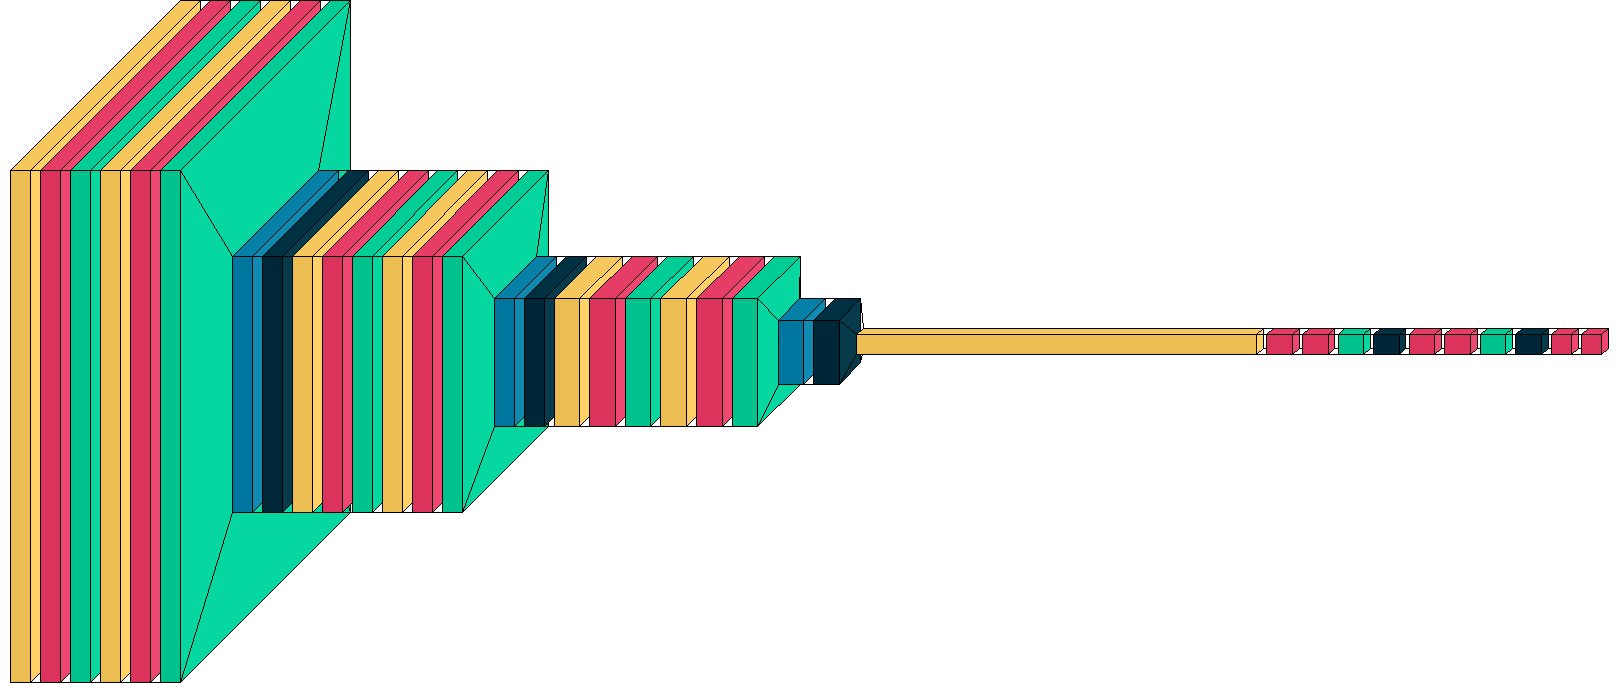

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/computing project/assets/isic-CNN.hdf5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
model.compile( loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics = ['accuracy'])

In [ ]:
epochs=30
history = model.fit(
    train_ds,
    epochs = epochs,
    validation_data = val_ds,
    
   )

Epoch 1/30
125/125 [==============================] - 591s 5s/step - loss: 1.0077 - accuracy: 0.5901 - val_loss: 1.3698 - val_accuracy: 0.8067
Epoch 2/30
125/125 [==============================] - 12s 92ms/step - loss: 0.6887 - accuracy: 0.7177 - val_loss: 0.6834 - val_accuracy: 0.7900
Epoch 3/30
125/125 [==============================] - 11s 90ms/step - loss: 0.6071 - accuracy: 0.7405 - val_loss: 0.5156 - val_accuracy: 0.8050
Epoch 4/30
125/125 [==============================] - 11s 90ms/step - loss: 0.5669 - accuracy: 0.7617 - val_loss: 0.5060 - val_accuracy: 0.8067
Epoch 5/30
125/125 [==============================] - 11s 90ms/step - loss: 0.5162 - accuracy: 0.7816 - val_loss: 0.5084 - val_accuracy: 0.8067
Epoch 6/30
125/125 [==============================] - 11s 90ms/step - loss: 0.5145 - accuracy: 0.7889 - val_loss: 0.5144 - val_accuracy: 0.7750
Epoch 7/30
125/125 [==============================] - 12s 91ms/step - loss: 0.5410 - accuracy: 0.7695 - val_loss: 0.5056 - val_accuracy: 

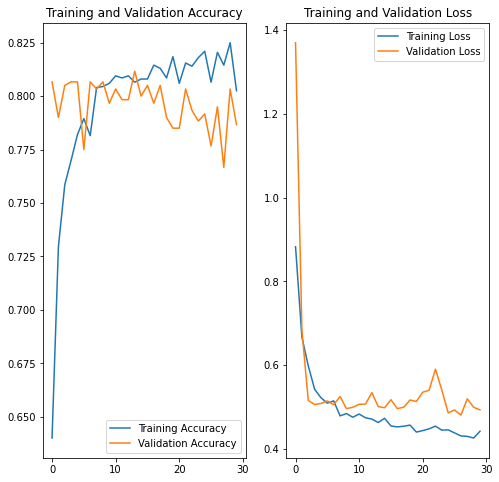

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
acc = history.history['val_accuracy']
ACC_index =acc.index( max(acc))
ACC=history.history['accuracy'][ACC_index]
LOSS= history.history['loss'][ACC_index]
val_ACC= history.history['val_accuracy'][ACC_index]
val_loss=history.history['val_loss'][ACC_index]
print('Train loss:',LOSS)
print('Train accuracy:',ACC)
print('-------------------------------')
print('Validation loss:',val_loss)
print('Validation accuracy:',val_ACC)

Train loss: 0.4629353880882263
Train accuracy: 0.8065000176429749
-------------------------------
Validation loss: 0.5009317994117737
Validation accuracy: 0.8116666674613953


This image most likely belongs to other with a 68.35 percent confidence.


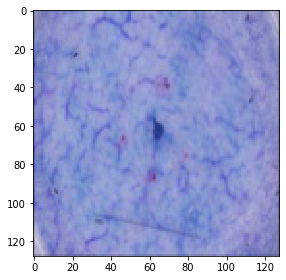

In [ ]:
path = '/content/drive/MyDrive/computing project/ISIC_2017_TEST_Dir/1/ISIC_0012705.jpg'
img = keras.preprocessing.image.load_img(
    path, target_size=(128, 128)
)
imshow(path)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(Class_name[np.argmax(score)], 100 * np.max(score))
)

#Multiclass classification

Creat a new csv file with 3 classes

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/computing project/ISIC-2017_Training_Part3_GroundTruth.csv")
conditions = [
    (df['melanoma'] ==1) & (df['seborrheic_keratosis']==0),
    (df['melanoma'] ==0 )& (df['seborrheic_keratosis']==0),
    (df['melanoma'] ==0 )& (df['seborrheic_keratosis']==1) 
            ]
values = [0,1,2]
df['class'] = np.select(conditions, values)
df.to_csv("/content/drive/MyDrive/computing project/ISIC-2017_Training_GroundTruth2.csv")
print('NEW CSV FILE HAS BEEN ADDED')

NEW CSV FILE HAS BEEN ADDED


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_Part3_GroundTruth.csv")
conditions = [
    (df['melanoma'] ==1) & (df['seborrheic_keratosis']==0),
    (df['melanoma'] ==0 )& (df['seborrheic_keratosis']==0),
    (df['melanoma'] ==0 )& (df['seborrheic_keratosis']==1) 
            ]
values = [0,1,2]
df['class'] = np.select(conditions, values)
df.to_csv("/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_GroundTruth2.csv")
print('NEW CSV FILE HAS BEEN ADDED')

NEW CSV FILE HAS BEEN ADDED


Text(0, 0.5, 'Number of images')

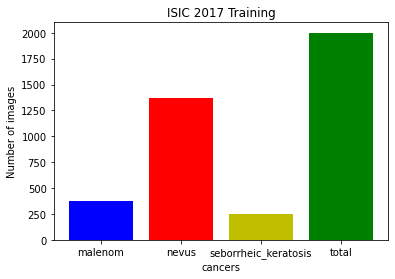

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/computing project/ISIC-2017_Training_GroundTruth2.csv")
X=0
Y=0
Z=0
for i in range(len(df)):
 clas = df['class'][i]
 if clas == 0 : 
   X=X+1
 elif clas== 1:
   Y=Y+1
 elif clas== 2 :
   Z=Z+1
plt.bar(x='malenom',height=X ,color='b')
plt.bar(x='nevus',height=Y ,color='r')
plt.bar(x='seborrheic_keratosis',height=Z ,color='y')
plt.bar(x='total',height=X+Y+Z ,color='g')
plt.title("ISIC 2017 Training")
plt.xlabel("cancers")
plt.ylabel("Number of images")

Text(0, 0.5, 'Number of images')

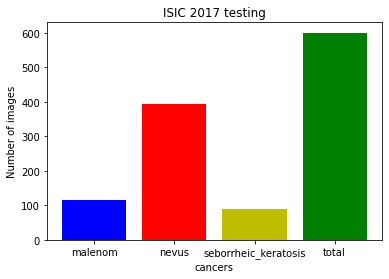

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_GroundTruth2.csv")
X=0
Y=0
Z=0
for i in range(len(df)):
 clas = df['class'][i]
 if clas == 0 : 
   X=X+1
 elif clas== 1:
   Y=Y+1
 elif clas== 2 :
   Z=Z+1

plt.bar(x='malenom',height=X ,color='b')
plt.bar(x='nevus',height=Y ,color='r')
plt.bar(x='seborrheic_keratosis',height=Z ,color='y')
plt.bar(x='total',height=X+Y+Z ,color='g')
plt.title("ISIC 2017 testing")
plt.xlabel("cancers")
plt.ylabel("Number of images")

Creat a diractory

In [ ]:
def creat_Dir_train2(csv):
  df = pd.read_csv(csv)
  sys.stdout.flush()
  for i in tqdm(range(len(df))):
    image_id= df['image_id'][i]
    clas = df['class'][i]
    if clas == 0 : 
      original = training_folder_resize+'/'+image_id+'.jpg'
      target = '/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir2/0/'+image_id+'.jpg'
      shutil.copyfile(original, target)
    
    elif clas == 1 : 
      original = training_folder_resize+'/'+image_id+'.jpg'
      target = '/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir2/1/'+image_id+'.jpg'
      shutil.copyfile(original, target)
      
    elif clas == 2 :
      original = training_folder_resize+'/'+image_id+'.jpg'
      target = '/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir2/2/'+image_id+'.jpg'
      shutil.copyfile(original, target)


In [ ]:
creat_Dir_train2('/content/drive/MyDrive/computing project/ISIC-2017_Training_GroundTruth2.csv')

100%|██████████| 2000/2000 [00:22<00:00, 89.06it/s]


In [ ]:
def creat_Dir_test2(csv):
  df = pd.read_csv(csv)
  sys.stdout.flush()
  for i in tqdm(range(len(df))):
    image_id= df['image_id'][i]
    clas = df['class'][i]
    if clas == 0 : 
      original = test_folder_resize+'/'+image_id+'.jpg'
      target = '/content/drive/MyDrive/computing project/ISIC_2017_Test_Dir2/0/'+image_id+'.jpg'
      shutil.copyfile(original, target)
    
    elif clas == 1 : 
      original = test_folder_resize+'/'+image_id+'.jpg'
      target = '/content/drive/MyDrive/computing project/ISIC_2017_Test_Dir2/1/'+image_id+'.jpg'
      shutil.copyfile(original, target)
      
    elif clas == 2 :
      original = test_folder_resize+'/'+image_id+'.jpg'
      target = '/content/drive/MyDrive/computing project/ISIC_2017_Test_Dir2/2/'+image_id+'.jpg'
      shutil.copyfile(original, target)
      

In [ ]:
creat_Dir_test2("/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_GroundTruth2.csv")

100%|██████████| 600/600 [00:06<00:00, 88.30it/s]


loading the data set

In [ ]:
Class_name2=['melanom','nevus','seborrheic_keratosis']

In [ ]:
train_dir2='/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir2'
train_ds2=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir2, labels='inferred', label_mode='int',
    class_names=["0","1","2"], color_mode='rgb', batch_size=32, image_size=(IMG_HEIGHT,
    IMG_WIDTH), shuffle=True, seed=300, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

Found 2000 files belonging to 3 classes.


In [90]:
test_dir2='/content/drive/MyDrive/computing project/ISIC_2017_Test_Dir2'
val_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir2, labels='inferred', label_mode='int',
    class_names=["0","1",'2'], color_mode='rgb', batch_size=32, image_size=(IMG_HEIGHT,
    IMG_WIDTH), shuffle=True, seed=300, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

Found 600 files belonging to 3 classes.


In [91]:
train_ds2 = train_ds2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds2 = val_ds2.cache().prefetch(buffer_size=AUTOTUNE)

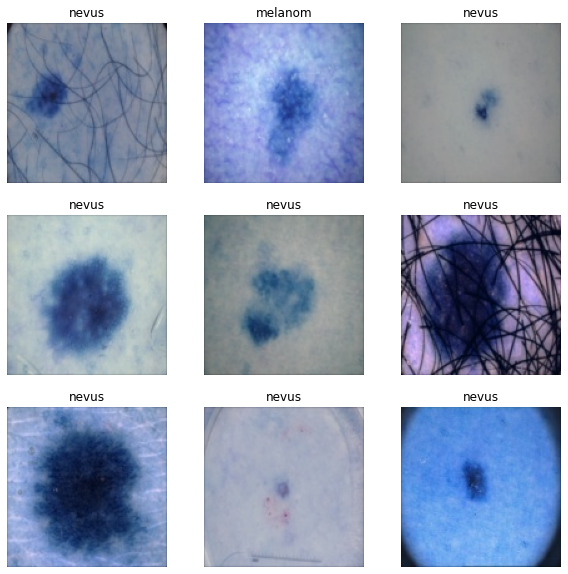

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds2.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(Class_name2[labels[i]])
    plt.axis("off")

Normalization

In [ ]:
normalized_ds = train_ds2.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.854902


Model

In [ ]:
model2 = Sequential()
data_augmentation,
# First CONV-ReLU Layer
model2.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (IMG_HEIGHT,IMG_WIDTH, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

# Second CONV-ReLU Layer
model2.add(Conv2D(64, (3, 3), padding = "same", input_shape = (IMG_HEIGHT,IMG_WIDTH, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

# Max Pooling with Dropout 
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# 3rd set of CONV-ReLU Layers
model2.add(Conv2D(128, (3, 3), padding="same"))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

# 4th Set of CONV-ReLU Layers
model2.add(Conv2D(128, (3, 3), padding="same"))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

# Max Pooling with Dropout 
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# 5th Set of CONV-ReLU Layers
model2.add(Conv2D(256, (3, 3), padding="same"))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

# 6th Set of CONV-ReLU Layers
model2.add(Conv2D(256, (3, 3), padding="same"))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

# Max Pooling with Dropout 
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# First set of FC or Dense Layers
model2.add(Flatten())
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

# Second set of FC or Dense Layers
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

# Final Dense Layer
model2.add(Dense(3))
model2.add(Activation("softmax"))

print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)       

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=30
history2 = model2.fit(
  train_ds2,
  validation_data=val_ds2,
  epochs=epochs
)

Epoch 1/30
63/63 [==============================] - 19s 194ms/step - loss: 5.9953 - accuracy: 0.4411 - val_loss: 20.4228 - val_accuracy: 0.0433
Epoch 2/30
63/63 [==============================] - 11s 174ms/step - loss: 0.6098 - accuracy: 0.7656 - val_loss: 1.8545 - val_accuracy: 0.6750
Epoch 3/30
63/63 [==============================] - 11s 174ms/step - loss: 0.4733 - accuracy: 0.8152 - val_loss: 1.3486 - val_accuracy: 0.6333
Epoch 4/30
63/63 [==============================] - 11s 174ms/step - loss: 0.3660 - accuracy: 0.8719 - val_loss: 1.5481 - val_accuracy: 0.6917
Epoch 5/30
63/63 [==============================] - 11s 175ms/step - loss: 0.3132 - accuracy: 0.8804 - val_loss: 1.3855 - val_accuracy: 0.7100
Epoch 6/30
63/63 [==============================] - 11s 173ms/step - loss: 0.1771 - accuracy: 0.9334 - val_loss: 1.3772 - val_accuracy: 0.6550
Epoch 7/30
63/63 [==============================] - 11s 173ms/step - loss: 0.1503 - accuracy: 0.9529 - val_loss: 1.6199 - val_accuracy: 0.675

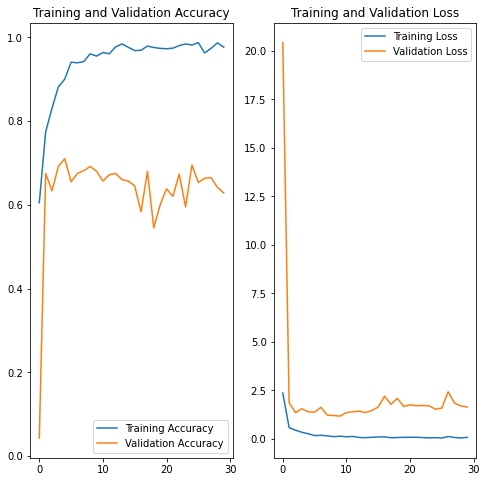

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
acc = history2.history['val_accuracy']
ACC_index =acc.index( max(acc))
ACC=history2.history['accuracy'][ACC_index]
LOSS= history2.history['loss'][ACC_index]
val_ACC= history2.history['val_accuracy'][ACC_index]
val_loss=history2.history['val_loss'][ACC_index]
print('Train loss:',LOSS)
print('Train accuracy:',ACC)
print('-------------------------------')
print('Validation loss:',val_loss)
print('Validation accuracy:',val_ACC)

Train loss: 0.24203766882419586
Train accuracy: 0.9125000238418579
-------------------------------
Validation loss: 1.0340023040771484
Validation accuracy: 0.7283333539962769


This image most likely belongs to nevus with a 56.19 percent confidence.


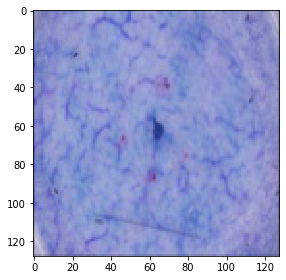

In [ ]:
path = '/content/drive/MyDrive/computing project/ISIC_2017_TEST_Dir/1/ISIC_0012705.jpg'
img = keras.preprocessing.image.load_img(
    path, target_size=(128, 128)
)
imshow(path)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(Class_name2[np.argmax(score)], 100 * np.max(score))
)

# Multi classification with otsu

In [ ]:
def creat_Dir_train3(csv):
  df = pd.read_csv(csv)
  sys.stdout.flush()
  for i in tqdm(range(len(df))):
    image_id= df['image_id'][i]
    clas = df['class'][i]
    if clas == 0 : 
      original = training_folder_resize+'/'+image_id+'.jpg'
      Otsu= training_Otsu_images_resize+'/'+image_id+'.png'
      img1= imread(original)
      img2= imread(Otsu)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir_Otsu/0/'+image_id+'.jpg',im)
    
    elif clas == 1 : 
      original = training_folder_resize+'/'+image_id+'.jpg'
      Otsu= training_Otsu_images_resize+'/'+image_id+'.png'
      img1= imread(original)
      img2= imread(Otsu)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir_Otsu/1/'+image_id+'.jpg',im)
      
    elif clas == 2 :
      original = training_folder_resize+'/'+image_id+'.jpg'
      Otsu= training_Otsu_images_resize+'/'+image_id+'.png'
      img1= imread(original)
      img2= imread(Otsu)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir_Otsu/2/'+image_id+'.jpg',im)

In [ ]:
creat_Dir_train3('/content/drive/MyDrive/computing project/ISIC-2017_Training_GroundTruth2.csv')

100%|██████████| 2000/2000 [14:19<00:00,  2.33it/s]


In [ ]:
def creat_Dir_test3(csv):
  df = pd.read_csv(csv)
  sys.stdout.flush()
  for i in tqdm(range(len(df))):
    image_id= df['image_id'][i]
    clas = df['class'][i]
    if clas == 0 : 
      original = test_folder_resize+'/'+image_id+'.jpg'
      Otsu= test_Otsu_images_resize+'/'+image_id+'.png'
      img1= imread(original)
      img2= imread(Otsu)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TEST_dir_Otsu/0/'+image_id+'.jpg',im)
    
    elif clas == 1 : 
      original = test_folder_resize+'/'+image_id+'.jpg'
      Otsu= test_Otsu_images_resize+'/'+image_id+'.png'
      img1= imread(original)
      img2= imread(Otsu)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TEST_dir_Otsu/1/'+image_id+'.jpg',im)
      
    elif clas == 2 :
      original = test_folder_resize+'/'+image_id+'.jpg'
      Otsu= test_Otsu_images_resize+'/'+image_id+'.png'
      img1= imread(original)
      img2= imread(Otsu)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TEST_dir_Otsu/2/'+image_id+'.jpg',im)

In [ ]:
creat_Dir_test3('/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_GroundTruth2.csv')

100%|██████████| 600/600 [04:34<00:00,  2.18it/s]


In [92]:
train_dir3='/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir_Otsu'
train_ds3=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir3, labels='inferred', label_mode='int',
    class_names=["0","1","2"], color_mode='rgb', batch_size=32, image_size=(IMG_HEIGHT,
    IMG_WIDTH), shuffle=True, seed=300, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

Found 2000 files belonging to 3 classes.


In [ ]:
test_dir3='/content/drive/MyDrive/computing project/ISIC_2017_TEST_dir_Otsu'
val_ds3 = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir3, labels='inferred', label_mode='int',
    class_names=["0","1",'2'], color_mode='rgb', batch_size=32, image_size=(IMG_HEIGHT,
    IMG_WIDTH), shuffle=True, seed=300, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

Found 600 files belonging to 3 classes.


In [ ]:
train_ds3 = train_ds3.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds3 = val_ds3.cache().prefetch(buffer_size=AUTOTUNE)

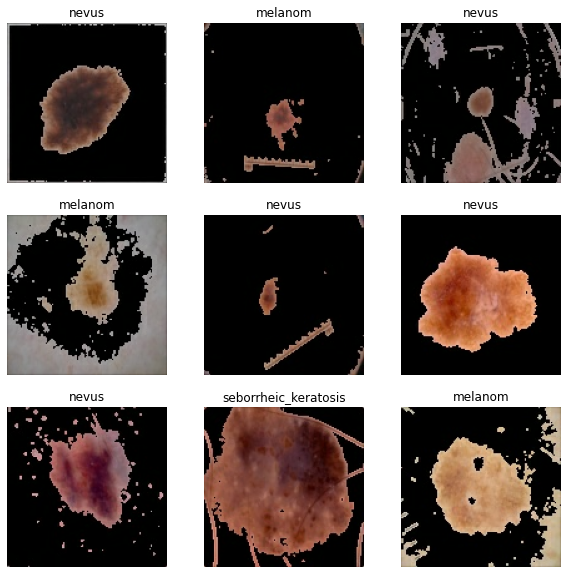

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds3.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(Class_name2[labels[i]])
    plt.axis("off")

In [93]:
normalized_ds = train_ds3.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.70980394


In [94]:
model3 = Sequential()
data_augmentation,
# First CONV-ReLU Layer
model3.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (IMG_HEIGHT,IMG_WIDTH, 3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())

# Second CONV-ReLU Layer
model3.add(Conv2D(64, (3, 3), padding = "same", input_shape = (IMG_HEIGHT,IMG_WIDTH, 3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())

# Max Pooling with Dropout 
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

# 3rd set of CONV-ReLU Layers
model3.add(Conv2D(128, (3, 3), padding="same"))
model3.add(Activation('relu'))
model3.add(BatchNormalization())

# 4th Set of CONV-ReLU Layers
model3.add(Conv2D(128, (3, 3), padding="same"))
model3.add(Activation('relu'))
model3.add(BatchNormalization())

# Max Pooling with Dropout 
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

# 5th Set of CONV-ReLU Layers
model3.add(Conv2D(256, (3, 3), padding="same"))
model3.add(Activation('relu'))
model3.add(BatchNormalization())

# 6th Set of CONV-ReLU Layers
model3.add(Conv2D(256, (3, 3), padding="same"))
model3.add(Activation('relu'))
model3.add(BatchNormalization())

# Max Pooling with Dropout 
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

# First set of FC or Dense Layers
model3.add(Flatten())
model3.add(Dense(256))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

# Second set of FC or Dense Layers
model3.add(Dense(256))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

# Final Dense Layer
model3.add(Dense(3))
model3.add(Activation("softmax"))

print(model3.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_27 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_28 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 64)       

In [95]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [96]:
epochs=30
history3 = model3.fit(
  train_ds3,
  validation_data=val_ds3,
  epochs=epochs
)

Epoch 1/30
63/63 [==============================] - 12s 166ms/step - loss: 1.7237 - accuracy: 0.3807 - val_loss: 2.7071 - val_accuracy: 0.1550
Epoch 2/30
63/63 [==============================] - 10s 153ms/step - loss: 1.2530 - accuracy: 0.4945 - val_loss: 1.3260 - val_accuracy: 0.6367
Epoch 3/30
63/63 [==============================] - 10s 153ms/step - loss: 1.0941 - accuracy: 0.5714 - val_loss: 1.0983 - val_accuracy: 0.5683
Epoch 4/30
63/63 [==============================] - 10s 153ms/step - loss: 0.9360 - accuracy: 0.6392 - val_loss: 1.0513 - val_accuracy: 0.6550
Epoch 5/30
63/63 [==============================] - 10s 153ms/step - loss: 0.9275 - accuracy: 0.6140 - val_loss: 1.0131 - val_accuracy: 0.6400
Epoch 6/30
63/63 [==============================] - 10s 153ms/step - loss: 0.8531 - accuracy: 0.6639 - val_loss: 1.1252 - val_accuracy: 0.6467
Epoch 7/30
63/63 [==============================] - 10s 153ms/step - loss: 0.8236 - accuracy: 0.6510 - val_loss: 0.9279 - val_accuracy: 0.6433

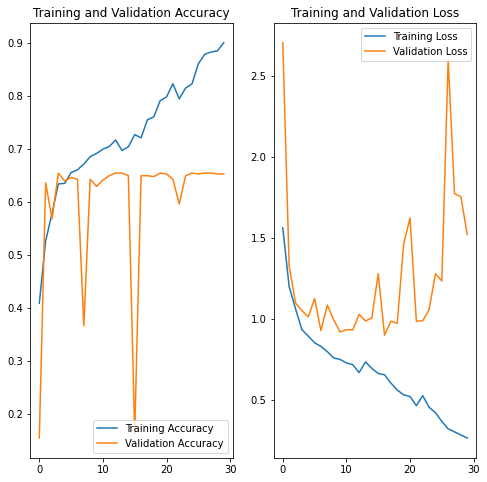

In [97]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [98]:
acc = history3.history['val_accuracy']
ACC_index =acc.index( max(acc))
ACC=history3.history['accuracy'][ACC_index]
LOSS= history3.history['loss'][ACC_index]
val_ACC= history3.history['val_accuracy'][ACC_index]
val_loss=history3.history['val_loss'][ACC_index]
print('Train loss:',LOSS)
print('Train accuracy:',ACC)
print('-------------------------------')
print('Validation loss:',val_loss)
print('Validation accuracy:',val_ACC)

Train loss: 0.9339292645454407
Train accuracy: 0.6345000267028809
-------------------------------
Validation loss: 1.0513253211975098
Validation accuracy: 0.6549999713897705


# MUlticlass classification with the Groundtruth mask

In [ ]:
def creat_Dir_train4(csv):
  df = pd.read_csv(csv)
  sys.stdout.flush()
  for i in tqdm(range(len(df))):
    image_id= df['image_id'][i]
    clas = df['class'][i]
    if clas == 0 : 
      original = training_folder_resize+'/'+image_id+'.jpg'
      mask= training_mask_folder_resize+'/'+image_id+'_segmentation'+'.png'
      img1= imread(original)
      img2= imread(mask)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir_MASK/0/'+image_id+'.jpg',im)
    
    elif clas == 1 : 
      original = training_folder_resize+'/'+image_id+'.jpg'
      mask= training_mask_folder_resize+'/'+image_id+'_segmentation'+'.png'
      img1= imread(original)
      img2= imread(mask)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir_MASK/1/'+image_id+'.jpg',im)
      
    elif clas == 2 :
      original = training_folder_resize+'/'+image_id+'.jpg'
      mask= training_mask_folder_resize+'/'+image_id+'_segmentation'+'.png'
      img1= imread(original)
      img2= imread(mask)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir_MASK/2/'+image_id+'.jpg',im)

In [ ]:
creat_Dir_train4('/content/drive/MyDrive/computing project/ISIC-2017_Training_GroundTruth2.csv')

100%|██████████| 2000/2000 [17:29<00:00,  1.91it/s]


In [ ]:
def creat_Dir_test4(csv):
  df = pd.read_csv(csv)
  sys.stdout.flush()
  for i in tqdm(range(len(df))):
    image_id= df['image_id'][i]
    clas = df['class'][i]
    if clas == 0 : 
      original = test_folder_resize+'/'+image_id+'.jpg'
      mask= test_mask_folder_resize+'/'+image_id+'_segmentation'+'.png'
      img1= imread(original)
      img2= imread(mask)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TEST_DIR_MASK/0/'+image_id+'.jpg',im)
    
    elif clas == 1 : 
      original = test_folder_resize+'/'+image_id+'.jpg'
      mask= test_mask_folder_resize+'/'+image_id+'_segmentation'+'.png'
      img1= imread(original)
      img2= imread(mask)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TEST_DIR_MASK/1/'+image_id+'.jpg',im)
      
    elif clas == 2 :
      original = test_folder_resize+'/'+image_id+'.jpg'
      mask= test_mask_folder_resize+'/'+image_id+'_segmentation'+'.png'
      img1= imread(original)
      img2= imread(mask)
      im2=img2[img2>0]=1
      img2= np.expand_dims(img2,axis=-1)
      im=np.multiply(img1 ,img2)
      cv2.imwrite('/content/drive/MyDrive/computing project/ISIC_2017_TEST_DIR_MASK/2/'+image_id+'.jpg',im)

In [ ]:
creat_Dir_test4('/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_GroundTruth2.csv')

100%|██████████| 600/600 [05:52<00:00,  1.70it/s]


In [ ]:
train_dir4='/content/drive/MyDrive/computing project/ISIC_2017_TRAIN_Dir_MASK'
train_ds4=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir4, labels='inferred', label_mode='int',
    class_names=["0","1","2"], color_mode='rgb', batch_size=32, image_size=(IMG_HEIGHT,
    IMG_WIDTH), shuffle=True, seed=300, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

Found 2000 files belonging to 3 classes.


In [ ]:
test_dir4='/content/drive/MyDrive/computing project/ISIC_2017_TEST_DIR_MASK'
val_ds4 = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir4, labels='inferred', label_mode='int',
    class_names=["0","1",'2'], color_mode='rgb', batch_size=32, image_size=(IMG_HEIGHT,
    IMG_WIDTH), shuffle=True, seed=300, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

Found 600 files belonging to 3 classes.


In [ ]:
train_ds4 = train_ds4.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds4 = val_ds4.cache().prefetch(buffer_size=AUTOTUNE)

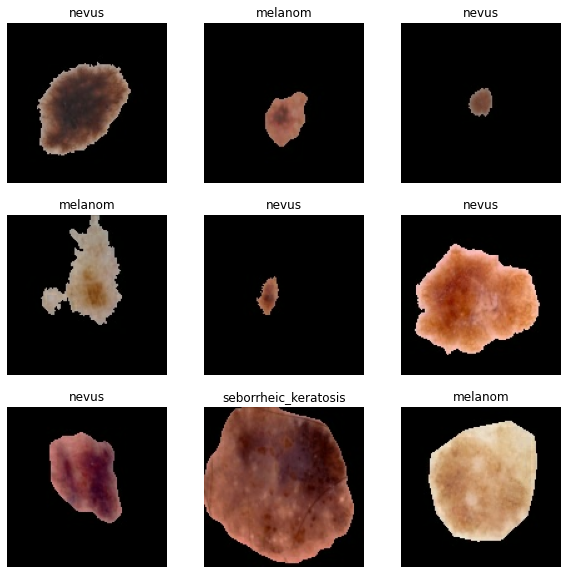

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds4.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(Class_name2[labels[i]])
    plt.axis("off")

In [ ]:
normalized_ds = train_ds4.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.7372549


In [ ]:
model4 = Sequential()
data_augmentation,
# First CONV-ReLU Layer
model4.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (IMG_HEIGHT,IMG_WIDTH, 3)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())

# Second CONV-ReLU Layer
model4.add(Conv2D(64, (3, 3), padding = "same", input_shape = (IMG_HEIGHT,IMG_WIDTH, 3)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())

# Max Pooling with Dropout 
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

# 3rd set of CONV-ReLU Layers
model4.add(Conv2D(128, (3, 3), padding="same"))
model4.add(Activation('relu'))
model4.add(BatchNormalization())

# 4th Set of CONV-ReLU Layers
model4.add(Conv2D(128, (3, 3), padding="same"))
model4.add(Activation('relu'))
model4.add(BatchNormalization())

# Max Pooling with Dropout 
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

# 5th Set of CONV-ReLU Layers
model4.add(Conv2D(256, (3, 3), padding="same"))
model4.add(Activation('relu'))
model4.add(BatchNormalization())

# 6th Set of CONV-ReLU Layers
model4.add(Conv2D(256, (3, 3), padding="same"))
model4.add(Activation('relu'))
model4.add(BatchNormalization())

# Max Pooling with Dropout 
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

# First set of FC or Dense Layers
model4.add(Flatten())
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

# Second set of FC or Dense Layers
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

# Final Dense Layer
model4.add(Dense(3))
model4.add(Activation("softmax"))

print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_9 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_10 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 64)       

In [ ]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=30
history4 = model4.fit(
  train_ds4,
  validation_data=val_ds4,
  epochs=epochs
)

Epoch 1/30
63/63 [==============================] - 503s 2s/step - loss: 1.7957 - accuracy: 0.3725 - val_loss: 2.1281 - val_accuracy: 0.6417
Epoch 2/30
63/63 [==============================] - 7s 116ms/step - loss: 1.1915 - accuracy: 0.5278 - val_loss: 1.3442 - val_accuracy: 0.6433
Epoch 3/30
63/63 [==============================] - 7s 116ms/step - loss: 1.0923 - accuracy: 0.5589 - val_loss: 1.2898 - val_accuracy: 0.6467
Epoch 4/30
63/63 [==============================] - 7s 117ms/step - loss: 1.0055 - accuracy: 0.5940 - val_loss: 1.1647 - val_accuracy: 0.6517
Epoch 5/30
63/63 [==============================] - 7s 117ms/step - loss: 0.8863 - accuracy: 0.6372 - val_loss: 1.1429 - val_accuracy: 0.6533
Epoch 6/30
63/63 [==============================] - 7s 118ms/step - loss: 0.8390 - accuracy: 0.6611 - val_loss: 1.2431 - val_accuracy: 0.3383
Epoch 7/30
63/63 [==============================] - 7s 119ms/step - loss: 0.8918 - accuracy: 0.6421 - val_loss: 1.3781 - val_accuracy: 0.2950
Epoch 8

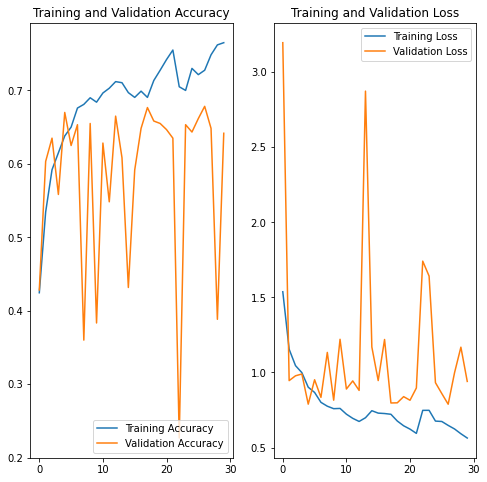

In [ ]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
acc = history4.history['val_accuracy']
ACC_index =acc.index( max(acc))
ACC=history4.history['accuracy'][ACC_index]
LOSS= history4.history['loss'][ACC_index]
val_ACC= history4.history['val_accuracy'][ACC_index]
val_loss=history4.history['val_loss'][ACC_index]
print('Train loss:',LOSS)
print('Train accuracy:',ACC)
print('-------------------------------')
print('Validation loss:',val_loss)
print('Validation accuracy:',val_ACC)

Train loss: 0.6472274661064148
Train accuracy: 0.7275000214576721
-------------------------------
Validation loss: 0.7881832122802734
Validation accuracy: 0.6783333420753479
